# LA-ICP-MS dataset processing
## required packets

In [1]:
from PIL import Image
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import napari
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

#from process_image import *

## basic settings

In [2]:
# select the datasource - if load_raw = True, the directory variable has to be set, else the xlsx_path
load_raw = True

base_path = "E:/nextcloud/Uni/WdB/Laser-ICP&EDX/Rohdaten/"

# xlsx source paths
xlsx_path = base_path + "KlikerWe2_Klinker_Berecih 2.xlsx"
#xlsx_path = base_path + "KlikerWe2_Klinker_Berecih 3.xlsx"

# raw source paths
directory = base_path + "Archiv/Bereich 2/"
#directory = base_path + "Archiv/Bereich 3/"
#directory = base_path + "Archiv/unbekannt/"

# gauss_smoothing_factor search a good value from 1 to 7 delivers good results. to disable smoothing, set the value to 0
smooth_y  = 2
# interpolate lines between the lines in x direction (linear interpolation)
stretch_x = 6

# extracted from the xlsx
spot_distance_y = 0.579150579150579
# extracted from a reference SEM image
spot_distance_x = 7/(stretch_x+1)

# set basic variables containing all elements and their respective colors in the napari editor
scaling = (spot_distance_y, spot_distance_x)
images = {}
elements  = []
colormaps = ["red" , "green", "blue", "yellow", "magenta", "cyan", "bop blue", "bop orange", "bop purple", "magma",  "gray"]

### helper functions

In [3]:
# find elements and prepare element arrays
def get_elements(df, elements):
    illegal_columns = ['ID', 'ID03', 'mp', 'µm', 'Time in Seconds '] + ['TB'] # TB contains some image data - but I do not know what exactly
    numbers = [ "\u2070", "\u00b9","\u00b2","\u00b3","\u2074","\u2075","\u2076","\u2077","\u2078", "\u2079" ]
    if len(elements) == 0: 
        elements = {}
        columns = df.columns.tolist()
        for c in illegal_columns:
            if c in columns: columns.remove(c)
        for p, element in enumerate(columns):
            e = re.split('(\d+)',element)
            if len(e) == 3:
                i = ""
                for n in e[1]:
                    i += numbers[int(n)]
                elements[element] = i+e[0]
            else:
                elements[element] = element
    return elements

# change data format, the orientation of the image and remove 1% outliers
def optimize_img(img):
    # in np array umwandeln und um 90° drehen
    np_img = np.rot90( np.flip( np.array(img), 0 ), 3 )
    element_max = np.percentile(np_img, 99) 
    #plt.hist(np_img.flatten(), bins = range(0,round(element_max[element]), 15)) 
    #plt.title("histogram {}".format(element)) 
    #plt.show()
    return np.clip(np_img, 0, element_max)  / element_max, element_max # normieren

# interpolate lines in x-direction
def strech_img(img, stretch_x=1):
    _, j = img.shape
    line_a = img[:,0]
    new_img = img
    for pos in range(j-1):
        line_b = img[:,pos+1]

        #linear interpolation
        if stretch_x == 1:
            new_img = np.insert(new_img, 2*pos+1, ((line_a + line_b) / 2), axis=1)
        else:
            for i in range(stretch_x):
                #new_img = np.insert(new_img, 2*pos+1, ((line_a + line_b) / 2), axis=1)
                new_img = np.insert(new_img, (stretch_x+1)*pos+(i+1), ((line_b - line_a) / (stretch_x+1) * (i+1) + line_a), axis=1) #    ((line_a + line_b) / (stretch_x+1))

        line_a = line_b

    return new_img

def process_ls_icp_ms_line(df, images, elements):    
    elements = get_elements(df, elements)

    for element in elements.keys():
        if not element in images: images[element] = []
        if smooth_y > 0:
            images[element].append( gaussian_filter1d(df[element].tolist(), smooth_y) )
        else:
            images[element].append( df[element].tolist() )

    return elements, images

## open XLSX file

In [4]:
if not load_raw:    
    xl = pd.ExcelFile(xlsx_path)
    sheets = xl.sheet_names
    sheets.sort()

    for sheet in sheets:
        df = xl.parse(sheet)
        elements, images = process_ls_icp_ms_line(df, images, elements)

## open RAW XL files

In [5]:
if load_raw:
    if ( os.path.isdir( directory ) ):
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if not '~lock' in filename:
                df  = pd.read_csv(directory+filename, header=1)
                elements, images = process_ls_icp_ms_line(df, images, elements)

In [6]:
first_e = list(elements.keys())[0] # just selecting the first element for statistics and the following test plot
print('loaded a dataset with the dimensions {} x {} datapoints and {} elements:'.format( len(images[first_e]), len(images[first_e][0]), len(images) ) )
print(list(elements.values()))

loaded a dataset with the dimensions 50 x 700 datapoints and 11 elements:
['²³Na', '²⁴Mg', '²⁷Al', '³⁹K', '⁴⁷Ti', '⁵¹V', '⁵²Cr', '⁵⁵Mn', '⁶⁶Zn', '⁸⁷Rb', '¹³⁷Ba']


## preprocess images

In [7]:
np_images = {}
element_max = {}
for element in elements.keys():
    np_images[element], element_max[element] = optimize_img( images[element] )
    if stretch_x > 0: np_images[element] = strech_img( np_images[element], stretch_x )

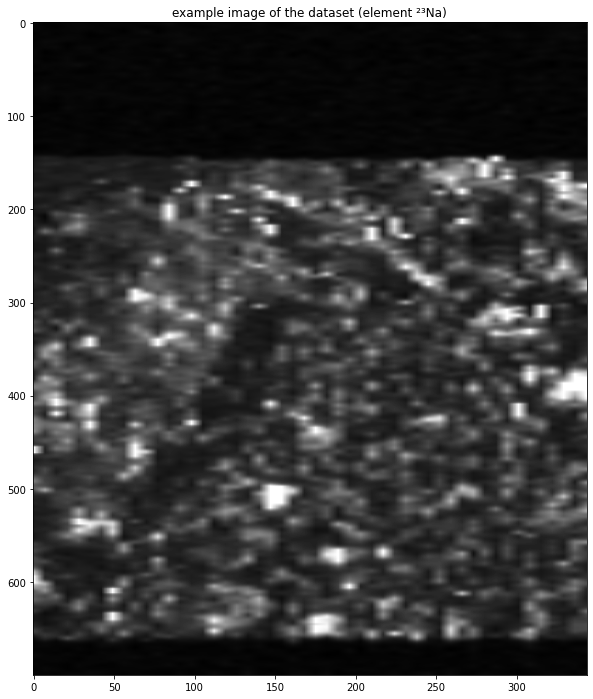

In [8]:
img, _ = optimize_img( images[first_e] )
plt.rcParams['figure.figsize'] = [12, 12]
plt.title('example image of the dataset (element {})'.format(elements[first_e]))
plt.imshow(strech_img( img, stretch_x), aspect=spot_distance_y/spot_distance_x, cmap='gray', interpolation=None);

## saving images

In [9]:
for i, element in enumerate(elements.keys()):
    img, _ = optimize_img( images[element] )
    img = strech_img( img, 12)*65535
    
    info = {}
    info[282] = round(1/(7/13*1000), 6)
    info[283] = round(1/(spot_distance_y*1000), 6)
    info[270] = "ImageJ=" + 'LA_ICP_MS' + "\nunit=" + 'nm'
    pil_img = Image.fromarray(img.astype(np.uint16))
    pil_img.save( base_path + 'LA-ICP-MS_{}.tif'.format(element), tiffinfo = info )

## show in the napari viewer

In [10]:
selected_elements = elements.keys()#['Na23',  'Mg24', 'Al27',    'K39',    'Ti47',  'V51',     'Cr52',       'Mn55',       'Zn66',    'Rb87', 'Ba137' ]
with napari.gui_qt():
    viewer = napari.Viewer()
    for i, element in enumerate(selected_elements):
        new_layer = viewer.add_image(np_images[element], name='LA-ICP-MS [{}]'.format(elements[element]), scale=scaling, colormap=colormaps[i], opacity=1/len(selected_elements), blending="additive", rendering="iso")
    viewer.scale_bar.visible = True